<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Examples.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Examples: Multiple linear regression: Advanced regression analysis 2
© ExploreAI Academy

In this notebook, we will delve into assessing the quality of a regression model by examining residuals for independence, homoscedasticity, normality, and outliers. We'll visualise residuals against predictor variables and fitted values and inspect histograms and Q-Q plots to ensure normality. Furthermore, we'll utilise Cook's distance to identify influential outliers.

## Learning Objectives

By the end of this notebook, you should be able to:
* Interpret scatter plots of residuals against predictor variables to assess independence.
* Identify homoscedasticity by examining the relationship between fitted values and residuals.
* Evaluate the normality of residuals through histograms and Q-Q plots.
* Utilise Cook's distance to detect influential outliers in the dataset.
* Apply statistical techniques to ensure the robustness of regression models.


## The dataset - `mtcars`

For this train, we continue to make use of the `mtcars` dataset. We begin by importing some libraries which will help us load and explore our data. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import ssl

# Set the path to the CA certificates bundle
ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/mtcars.csv', index_col=0)
df.head(10)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
model,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,32.0,20.090625,6.026948,10.400,15.42500,19.200,22.80,33.900
cyl,32.0,6.187500,1.785922,4.000,4.00000,6.000,8.00,8.000
disp,32.0,230.721875,123.938694,71.100,120.82500,196.300,326.00,472.000
hp,32.0,146.687500,68.562868,52.000,96.50000,123.000,180.00,335.000
drat,32.0,3.596563,0.534679,2.760,3.08000,3.695,3.92,4.930
wt,32.0,3.217250,0.978457,1.513,2.58125,3.325,3.61,5.424
qsec,32.0,17.848750,1.786943,14.500,16.89250,17.710,18.90,22.900
vs,32.0,0.437500,0.504016,0.000,0.00000,0.000,1.00,1.000
am,32.0,0.406250,0.498991,0.000,0.00000,0.000,1.00,1.000
gear,32.0,3.687500,0.737804,3.000,3.00000,4.000,4.00,5.000


Let's create a copy of the dataset so that we can play with and process it using `statsmodels.OLS()`.

In [5]:
df1 = df.copy()

## Fitting the model using `statsmodels.OLS`

As was previously motivated, `sklearn` is limited in terms of the metrics and tools available to evaluate the appropriateness of the regression models we fit. Thus, to further expand our analysis, we import the `statsmodels` library, generate the regression string, fit the model using `ols` and finally print the model summary.

In [6]:
import statsmodels.formula.api as sm

In [7]:
#Generate the regression string
formula_str = df1.columns[0]+' ~ '+'+'.join(df1.columns[1:]); formula_str

'mpg ~ cyl+disp+hp+drat+wt+qsec+vs+am+gear+carb'

In [8]:
#Construct and fit the model using ols
model=sm.ols(formula=formula_str, data=df1)
fitted = model.fit()

In [9]:
#Print the model summary
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     13.93
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           3.79e-07
Time:                        11:56:25   Log-Likelihood:                -69.855
No. Observations:                  32   AIC:                             161.7
Df Residuals:                      21   BIC:                             177.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3034     18.718      0.657      0.5

## Checking for independence

We have done checks for linearity and multicollinearity, which both refer to the predictor variables. Now we'll move on to checking some of the artefacts of the fitted model for three more statistical phenomena, which will further help us determine its quality.

### Residuals vs. predictor variable plots 

The first check we do involves plotting the residuals (vertical distances between each data point and the regression hyperplane). We are looking to confirm the independence assumption here, i.e., the residuals should be independent. If they are, we will see:

- Residuals approximately uniformly randomly distributed about the zero x-axes;

- Residuals not forming specific clusters.

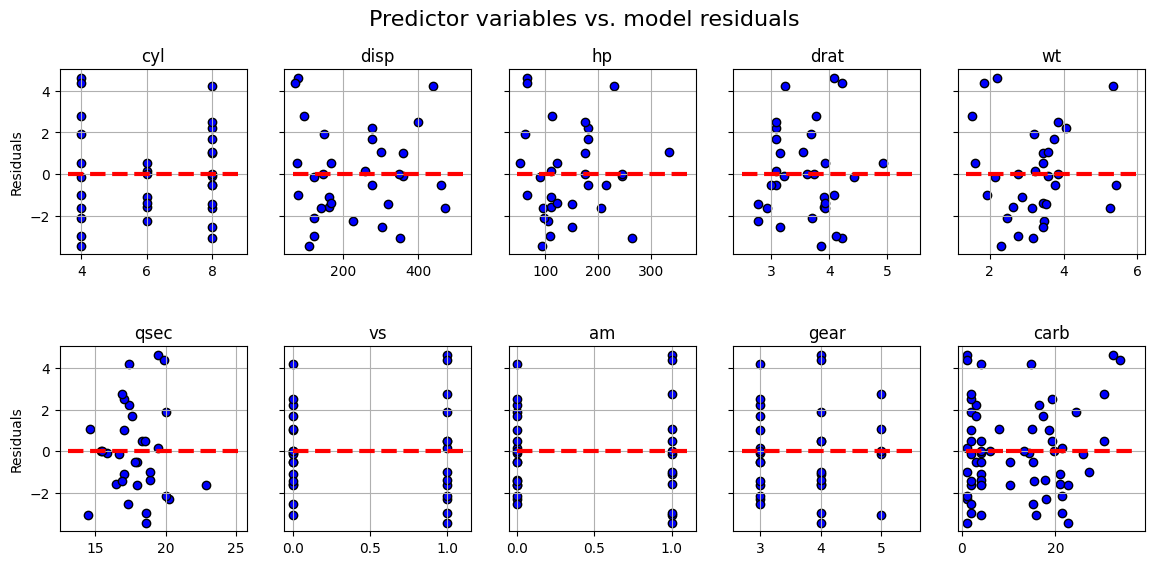

In [22]:
fig, axs = plt.subplots(2,5, figsize=(14,6),sharey=True)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
fig.suptitle('Predictor variables vs. model residuals', fontsize=16)
axs = axs.ravel()

for index, column in enumerate(df.columns):
    axs[index-1].set_title("{}".format(column),fontsize=12)
    axs[index-1].scatter(x=df[column],y=fitted.resid,color='blue',edgecolor='k')
    axs[index-1].grid(True)
    xmin = min(df[column])
    xmax = max(df[column])
    axs[index-1].hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    if index == 1 or index == 6:
        axs[index-1].set_ylabel('Residuals')

Observing the plots above, two things are relatively clear:

- All of the residuals are slightly skewed to the positive (reaching +5 to the positive but only up to about -3 to the negative);

- There is no obvious clustering, except for `cyl` which may present a cluster on the value 6.

Our conclusion here is that the residuals are largely independent.

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>